In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 2. Read the CSV file and assign the 'Price' column to the variable df1
df = pd.read_csv('/Users/baoan/Desktop/STB-His-torical-Data-19.csv')
df1 = df.reset_index()['Price']
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/19/2017,12400.0,12450.0,12550.0,12350.0,2.61M,-0.40%
1,05/22/2017,12700.0,12400.0,12900.0,12350.0,5.15M,2.42%
2,05/23/2017,12400.0,12800.0,12900.0,12400.0,3.42M,-2.36%
3,05/24/2017,12550.0,12500.0,12750.0,12400.0,2.94M,1.21%
4,05/25/2017,12400.0,12550.0,12750.0,12350.0,4.88M,-1.20%
...,...,...,...,...,...,...,...
1495,05/15/2023,27000.0,27000.0,27600.0,26900.0,29.85M,0.75%
1496,05/16/2023,27400.0,27000.0,27550.0,27000.0,13.15M,1.48%
1497,05/17/2023,27000.0,27400.0,27500.0,26900.0,17.69M,-1.46%
1498,05/18/2023,27200.0,27150.0,27500.0,27000.0,15.19M,0.74%


In [3]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [4]:
# Chia train test
train_size = int(0.75 * len(df1))
test_size = int(0.15 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [5]:
# Define BDLM model
with pm.Model() as model:
    level_coefficient = pm.Normal('level_coefficient', mu=0, sd=1)
    trend_coefficient = pm.Normal('trend_coefficient', mu=0, sd=1)
    seasonal_coefficient = pm.Normal('seasonal_coefficient', mu=0, sd=1)
    
    level = pm.AR('level', rho=level_coefficient, sd=0.1, observed=train_data)
    trend = pm.AR('trend', rho=trend_coefficient, sd=0.1, observed=train_data)
    seasonal = pm.AR('seasonal', rho=seasonal_coefficient, sd=0.1, observed=train_data)
    
    bdlm = level + trend + seasonal
    bdlm = pm.Normal('bdlm', mu=bdlm, sd=0.1, observed=train_data)
    
    trace = pm.sample(1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

/Users/baoan/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [seasonal_coefficient, trend_coefficient, level_coefficient]


In [6]:
# Dự báo dữ liệu test và val
predict_train = posterior_predictive['bdlm'].mean(axis=0)
predict_test = posterior_predictive['bdlm'][train_size:train_size + test_size].mean(axis=0)
predict_val = posterior_predictive['bdlm'][train_size + test_size:].mean(axis=0)

In [7]:
# Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((predict_val[:val_size].reshape(-1) - val_data.reshape(-1)) ** 2))
test_rmse = np.sqrt(np.mean((predict_test[:test_size].reshape(-1) - test_data.reshape(-1)) ** 2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.2067911827371238
Testing RMSE: 0.3000126169531105


In [8]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs(predict_val[:val_size].reshape(-1) - val_data.reshape(-1)) / np.abs(val_data.reshape(-1)))
test_mape = np.mean(np.abs(predict_test[:test_size].reshape(-1) - test_data.reshape(-1)) / np.abs(test_data.reshape(-1)))
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.3924202925086735
Testing MAPE: 0.38516251394824735


In [9]:
# Calculate MAE for validation data
valid_mae = np.mean(np.abs(predict_val[:val_size].reshape(-1) - val_data.reshape(-1)))
# Calculate MAE for test data
test_mae = np.mean(np.abs(predict_test[:test_size].reshape(-1) - test_data.reshape(-1)))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.1738983791282869
Testing MAE: 0.26021572248961905


In [10]:
# Lấy dự đoán cho 30 ngày tiếp theo
predict_steps = 30
predict_future = posterior_predictive['bdlm'][:, -predict_steps:].mean(axis=0)
predict_future = predict_future.flatten()
predict_future = predict_future[-30:]

# In dự đoán 30 ngày tiếp theo
print('Next 30 days predict:')
for i, predict in enumerate(predict_future):
    print('Day {}: {}'.format(i+1, predict))


Next 30 days predict:
Day 1: 1.7880235485087994
Day 2: 1.9388988724425307
Day 3: 1.9123718813067663
Day 4: 1.9130621245698227
Day 5: 1.9367334624461665
Day 6: 2.018247484577202
Day 7: 2.027305398361857
Day 8: 1.9897293952583532
Day 9: 2.0058183822384934
Day 10: 2.0537112112296567
Day 11: 2.057486355056501
Day 12: 1.987819345312285
Day 13: 1.9966476044100747
Day 14: 1.9744745851686862
Day 15: 1.9848881626673354
Day 16: 1.9230893716499529
Day 17: 1.921652749182621
Day 18: 2.0170848079782924
Day 19: 2.0374054455338326
Day 20: 2.0286058941495857
Day 21: 2.027692096891516
Day 22: 2.0359596034666954
Day 23: 2.1626326323054337
Day 24: 2.1160952574020966
Day 25: 2.141621701682455
Day 26: 2.160312462514929
Day 27: 2.186212379604856
Day 28: 2.2225342805314376
Day 29: 2.142008282421385
Day 30: 2.1867017087103964


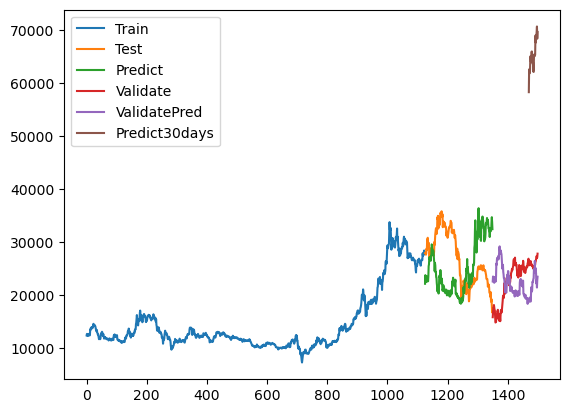

In [11]:
# Plot dữ liệu huấn luyện
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data.reshape(-1, 1)), label='Train')

# Plot dữ liệu kiểm tra
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data.reshape(-1, 1)), label='Test')

# Plot dữ liệu dự đoán trong khoảng kiểm tra
predict_test_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(predict_test_index, scaler.inverse_transform(predict_test[:test_size].reshape(-1, 1)), label='Predict')

# Plot dữ liệu validation
val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data.reshape(-1, 1)), label='Validate')

# Plot dữ liệu dự đoán trong khoảng validation
predict_val_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + val_size, step=1)
plt.plot(predict_val_index, scaler.inverse_transform(predict_val[:val_size].reshape(-1, 1)), label='ValidatePred')

# Plot dữ liệu dự đoán 30 ngày tiếp theo
predict_data_index = pd.RangeIndex(start=len(df1) - predict_steps, stop=len(df1), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(predict_future.reshape(-1, 1)), label='Predict30days')

# Định dạng trục và tiêu đề
plt.legend(['Train', 'Test', 'Predict', 'Validate', 'ValidatePred', 'Predict30days'])
plt.show()



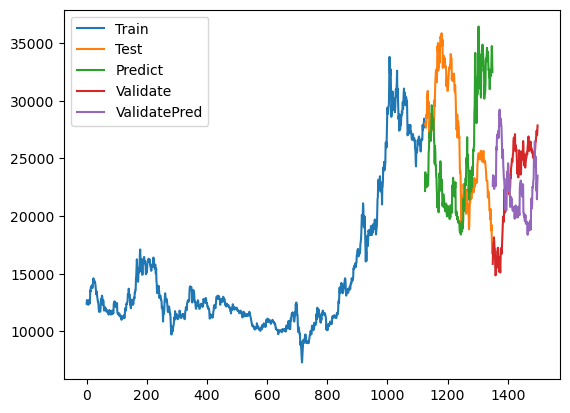

In [12]:
# Plot dữ liệu huấn luyện
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data.reshape(-1, 1)), label='Train')

# Plot dữ liệu kiểm tra
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data.reshape(-1, 1)), label='Test')

# Plot dữ liệu dự đoán trong khoảng kiểm tra
predict_test_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(predict_test_index, scaler.inverse_transform(predict_test[:test_size].reshape(-1, 1)), label='Predict')

# Plot dữ liệu validation
val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data.reshape(-1, 1)), label='Validate')

# Plot dữ liệu dự đoán trong khoảng validation
predict_val_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + val_size, step=1)
plt.plot(predict_val_index, scaler.inverse_transform(predict_val[:val_size].reshape(-1, 1)), label='ValidatePred')


# Định dạng trục và tiêu đề
plt.legend(['Train', 'Test', 'Predict', 'Validate', 'ValidatePred'])
plt.show()

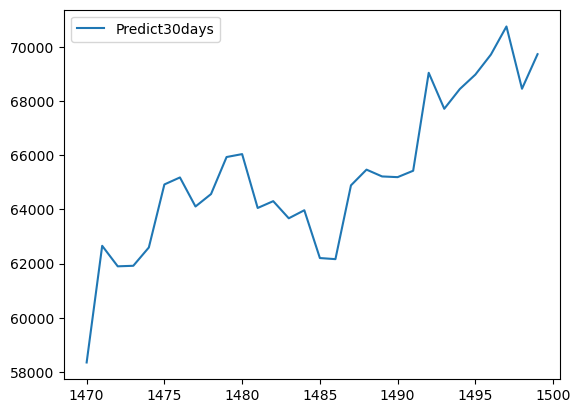

In [13]:
# Plot dữ liệu dự đoán 30 ngày tiếp theo
predict_data_index = pd.RangeIndex(start=len(df1) - predict_steps, stop=len(df1), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(predict_future.reshape(-1, 1)), label='Predict30days')

# Định dạng trục và tiêu đề
plt.legend(['Predict30days'])
plt.show()